## **Dataloaderのテスト**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

class ShopeeDataset(Dataset):
    def __init__(self, csv, transforms=None):

        self.csv = csv.reset_index()
        self.augmentations = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        text = row["title"]
        
        image = cv2.imread(row.filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
        
        
        return image,torch.tensor(row["label_group"])

In [3]:
INPUT_DIR = os.path.join("..","..","input","shopee-product-matching")

In [4]:
df = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
df['filepath'] = df['image'].apply(lambda x: os.path.join(INPUT_DIR, 'train_images', x))


from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label_group'] = encoder.fit_transform(df['label_group'])

df.head(5)

,posting_id,image,image_phash,title,label_group,filepath
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,..\..\input\shopee-product-matching\train_imag...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,..\..\input\shopee-product-matching\train_imag...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,..\..\input\shopee-product-matching\train_imag...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,..\..\input\shopee-product-matching\train_imag...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,..\..\input\shopee-product-matching\train_imag...


In [5]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

img_size = (512,512)
def get_train_transforms():
    return albumentations.Compose(
        [   
            albumentations.Resize(img_size[0],img_size[1],always_apply=True),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=120, p=0.8),
            albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
            #albumentations.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
            #albumentations.ShiftScaleRotate(
              #  shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            #),
            albumentations.Normalize(),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(img_size[0],img_size[1],always_apply=True),
            albumentations.Normalize(),
            ToTensorV2(p=1.0)
        ]
    )

label tensor(666)


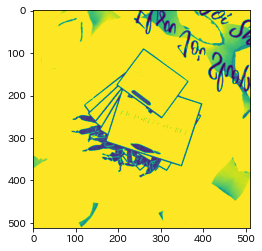

label tensor(6836)


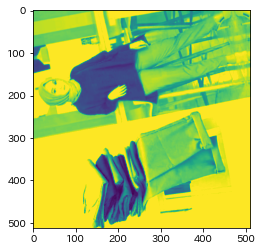

label tensor(6347)


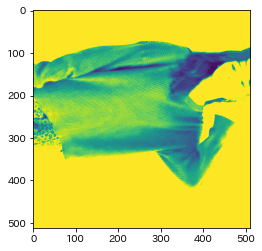

In [7]:
TRAIN_BATCH_SIZE = 5
train_loader = torch.utils.data.DataLoader(
                                            ShopeeDataset(csv=df[:15], transforms=get_train_transforms()),
                                            batch_size=TRAIN_BATCH_SIZE,
                                            pin_memory=True,
                                            drop_last=True,
                                            #num_workers=4
                                           )

for batch in train_loader:
    X = batch[0]
    y = batch[1]
    
    print("label",y[0])
    plt.imshow(X[0][0,:,:])
    plt.show()